In [ ]:
# Import tensorflow and additional libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

tf.keras.backend.clear_session()

# Check version
print('tensorflow version: ', tf.__version__)

tensorflow version:  2.8.0


In [ ]:
# Load : Fashion MNIST Dataest
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

size_of_train  = len(x_train)
size_of_test  = len(x_test)
num_of_class = 10

print('The Shape of dataset:', x_train[0].shape)
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

The Shape of dataset: (28, 28)
The number of train image: 60000
The number of test image: 10000


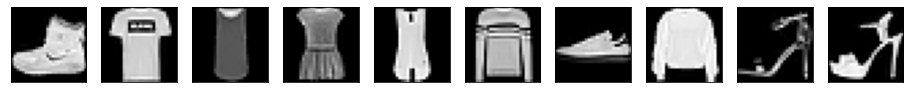

In [ ]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(x_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [ ]:
print('== Before normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

## Dataset Pre-processing ##
# Normalization
x_train = x_train/255.  
x_test = x_test/255. 

# Reshape(Adding channel)
x_train = x_train.reshape((size_of_train, 28, 28, 1))
x_test = x_test.reshape((size_of_test, 28, 28, 1))

print('\n== After normalization ==')
print('Image Shape:', x_train[0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(np.min(x_train[0]), np.mean(x_train[0]), np.max(x_train[0])))

== Before normalization ==
Image Shape: (28, 28)
Value MIN: 0, MEAN:97.25, MAX:255

== After normalization ==
Image Shape: (28, 28, 1)
Value MIN: 0, MEAN:0.38, MAX:1


In [ ]:
def channel_attention(x, name):
    ####Fill your code####
    ch = x.shape[-1]
    cr = ch / 4 # r = 4 
    gap = tf.keras.layers.GlobalAveragePooling2D()(x)
    fc_1 = tf.keras.layers.Dense(cr, activation='relu')(gap)
    fc_2 = tf.keras.layers.Dense(ch, activation='sigmoid')(fc_1)
    x_out = tf.keras.layers.Multiply()([x,fc_2])

    return  x_out

def spatial_attention(x, name):
    ####Fill your code####
    SA = tf.keras.layers.Conv2D(1, (3, 3),(1,1),padding='same' ,activation='sigmoid')(x)
    x_out = tf.keras.layers.Multiply()([x, SA])
    
    return  x_out
 

def autoencoder_block(x, filter, name): 
    x = tf.keras.layers.Conv2D(filters=filter, kernel_size=3, strides=(1, 1), padding='same', name=name+'_conv')(x)
    x = tf.keras.layers.BatchNormalization(name=name+'_bn')(x)
    x = tf.keras.layers.ReLU(name=name+'_relu')(x)
    return x

In [ ]:
##############################################
# Add Attention Block in AutoEncoder network #
##############################################

def autoencoder(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img

def autoencoder_channel(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = channel_attention(x,'channel_attention_1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = channel_attention(x,'channel_attention_2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    x = channel_attention(x,'channel_attention_3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = channel_attention(x,'channel_attention_4')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = channel_attention(x,'channel_attention_5')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = channel_attention(x,'channel_attention_6')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    


def autoencoder_spatial(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = spatial_attention(x,'spatial_attention_1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = spatial_attention(x,'spatial_attention_2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    x = spatial_attention(x,'spatial_attention_3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = spatial_attention(x,'spatial_attention_4')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = spatial_attention(x,'spatial_attention_5')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = spatial_attention(x,'spatial_attention_6')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    

def autoencoder_parellel_add(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    sa = channel_attention(x,'channel_attention_1')
    ca = spatial_attention(x,'spatial_attention_1')
    x = tf.keras.layers.Add()([ca,sa])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    sa = channel_attention(x,'channel_attention_2')
    ca = spatial_attention(x,'spatial_attention_2')
    x = tf.keras.layers.Add()([ca,sa])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    sa = channel_attention(x,'channel_attention_3')
    ca = spatial_attention(x,'spatial_attention_3')
    x = tf.keras.layers.Add()([ca,sa])

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    sa = channel_attention(x,'channel_attention_4')
    ca = spatial_attention(x,'spatial_attention_4')
    x = tf.keras.layers.Add()([ca,sa])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    sa = channel_attention(x,'channel_attention_5')
    ca = spatial_attention(x,'spatial_attention_5')
    x = tf.keras.layers.Add()([ca,sa])
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    sa = channel_attention(x,'channel_attention_6')
    ca = spatial_attention(x,'spatial_attention_6')
    x = tf.keras.layers.Add()([ca,sa])

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    

def autoencoder_parellel_mul(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    sa = channel_attention(x,'channel_attention_1')
    ca = spatial_attention(x,'spatial_attention_1')
    x = tf.keras.layers.Multiply()([ca,sa])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    sa = channel_attention(x,'channel_attention_2')
    ca = spatial_attention(x,'spatial_attention_2')
    x = tf.keras.layers.Multiply()([ca,sa])

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    sa = channel_attention(x,'channel_attention_3')
    ca = spatial_attention(x,'spatial_attention_3')
    x = tf.keras.layers.Multiply()([ca,sa])

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    sa = channel_attention(x,'channel_attention_4')
    ca = spatial_attention(x,'spatial_attention_4')
    x = tf.keras.layers.Multiply()([ca,sa])

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    sa = channel_attention(x,'channel_attention_5')
    ca = spatial_attention(x,'spatial_attention_5')
    x = tf.keras.layers.Multiply()([ca,sa])
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    sa = channel_attention(x,'channel_attention_6')
    ca = spatial_attention(x,'spatial_attention_6')
    x = tf.keras.layers.Multiply()([ca,sa])

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    


def autoencoder_serial_ca(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = channel_attention(x,'channel_attention_1')
    x = spatial_attention(x,'spatial_attention_1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = channel_attention(x,'channel_attention_2')
    x = spatial_attention(x,'spatial_attention_2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    x = channel_attention(x,'channel_attention_3')
    x = spatial_attention(x,'spatial_attention_3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = channel_attention(x,'channel_attention_4')
    x = spatial_attention(x,'spatial_attention_4')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = channel_attention(x,'channel_attention_5')
    x = spatial_attention(x,'spatial_attention_5')
 
    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = channel_attention(x,'channel_attention_6')
    x = spatial_attention(x,'spatial_attention_6')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    

def autoencoder_serial_sa(input):
    # Encoder
    x = autoencoder_block(input, 16, 'encoder1')
    x = spatial_attention(x,'spatial_attention_1')
    x = channel_attention(x,'channel_attention_1')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool1')(x)
    x = autoencoder_block(x, 32, 'encoder2')
    x = spatial_attention(x,'spatial_attention_2')
    x = channel_attention(x,'channel_attention_2')

    x = tf.keras.layers.MaxPooling2D((2, 2), name='encoder_pool2')(x)
    
    encoded_img = autoencoder_block(x, 64, 'encoder3')
    x = spatial_attention(x,'spatial_attention_3')
    x = channel_attention(x,'channel_attention_3')

    # Decoder
    x = autoencoder_block(encoded_img, 64, 'decoder1')
    x = spatial_attention(x,'spatial_attention_4')
    x = channel_attention(x,'channel_attention_4')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up1')(x)
    x = autoencoder_block(x, 32, 'decoder2')
    x = spatial_attention(x,'spatial_attention_5')
    x = channel_attention(x,'channel_attention_5')

    x = tf.keras.layers.UpSampling2D((2, 2), name='decoder_up2')(x)
    x = autoencoder_block(x, 16, 'decoder3')
    x = spatial_attention(x,'spatial_attention_6')
    x = channel_attention(x,'channel_attention_6')

    decoded_img = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=(1, 1), 
                                         activation='sigmoid', padding='same', 
                                         name='last_conv')(x)
    return decoded_img    

# Normal AutoEncoder Model Create / Summary
input_data = tf.keras.Input(shape=(28, 28, 1))

output_data = autoencoder(input_data)
output_channel_data = autoencoder_channel(input_data)
output_spatial_data = autoencoder_spatial(input_data)
output_parellel_add_data = autoencoder_parellel_add(input_data)
output_parellel_mul_data = autoencoder_parellel_mul(input_data)
output_serial_ca_data = autoencoder_serial_ca(input_data)
output_serial_sa_data = autoencoder_serial_sa(input_data)

model = tf.keras.Model(inputs=input_data, outputs=output_data)
model_channel  = tf.keras.Model(inputs=input_data, outputs=output_channel_data)
model_spatial  = tf.keras.Model(inputs=input_data, outputs=output_spatial_data)
model_parellel_add  = tf.keras.Model(inputs=input_data, outputs=output_parellel_add_data )
model_parellel_mul  = tf.keras.Model(inputs=input_data, outputs=output_parellel_mul_data)
model_serial_ca  = tf.keras.Model(inputs=input_data, outputs=output_serial_ca_data)
model_serial_sa  = tf.keras.Model(inputs=input_data, outputs=output_serial_sa_data)

model.summary()
model_channel.summary()
model_spatial.summary()
model_parellel_add.summary()
model_parellel_mul.summary()
model_serial_ca.summary()
model_serial_sa.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder1_conv (Conv2D)      (None, 28, 28, 16)        160       
                                                                 
 encoder1_bn (BatchNormaliza  (None, 28, 28, 16)       64        
 tion)                                                           
                                                                 
 encoder1_relu (ReLU)        (None, 28, 28, 16)        0         
                                                                 
 encoder_pool1 (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 encoder2_conv (Conv2D)      (None, 14, 14, 32)        4640  

In [ ]:
# Model Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])
model_channel.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_spatial.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_parellel_add.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_parellel_mul.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_serial_ca.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
model_serial_sa.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])

In [ ]:
# Training
print('Training Model')

# AutoEncoder는 input과 output이 같으므로 x_train을 넣어줌
history = model.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=15,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_channel = model_channel.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=15,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_spatial = model_spatial.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=15,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_parellel_add = model_parellel_add.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=15,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_parellel_mul = model_parellel_mul.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=15,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_serial_ca = model_serial_ca.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=15,
                    shuffle=True,
                    validation_data=(x_test, x_test))

history_serial_sa = model_serial_sa.fit(x_train, x_train, 
                    batch_size=16, 
                    epochs=15,
                    shuffle=True,
                    validation_data=(x_test, x_test))

Training Model
Epoch 1/15
3750/3750 [==============================] - 38s 9ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0035 - val_mse: 0.0035
Epoch 2/15
3750/3750 [==============================] - 34s 9ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0036 - val_mse: 0.0036
Epoch 3/15
3750/3750 [==============================] - 34s 9ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 4/15
3750/3750 [==============================] - 34s 9ms/step - loss: 0.0025 - mse: 0.0025 - val_loss: 0.0026 - val_mse: 0.0026
Epoch 5/15
3750/3750 [==============================] - 34s 9ms/step - loss: 0.0024 - mse: 0.0024 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 6/15
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0022 - mse: 0.0022 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 7/15
3750/3750 [==============================] - 33s 9ms/step - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0023 - val_mse: 0.0023
Epoch 8/15
3750/3750 [==================

In [ ]:
# Model Predict
recons = model.predict(x_test)
recons_channel = model_channel.predict(x_test)
recons_spatial = model_spatial.predict(x_test)
recons_parellel_add = model_parellel_add.predict(x_test)
recons_parellel_mul = model_parellel_mul.predict(x_test)
recons_serial_ca = model_serial_ca.predict(x_test)
recons_serial_sa = model_serial_sa.predict(x_test)

In [ ]:
recons = recons.reshape(-1, 28, 28)
recons_channel = recons_channel.reshape(-1, 28, 28)
recons_spatial = recons_spatial.reshape(-1, 28, 28)
recons_parellel_add = recons_parellel_add.reshape(-1, 28, 28)
recons_parellel_mul = recons_parellel_mul.reshape(-1, 28, 28)
recons_serial_ca = recons_serial_ca.reshape(-1, 28, 28)
recons_serial_sa = recons_serial_sa.reshape(-1, 28, 28)

test_imgs = (x_test * 255).reshape(-1, 28, 28)

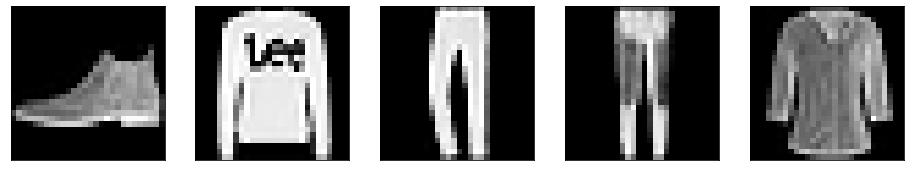

In [ ]:
# Test Data Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(test_imgs[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

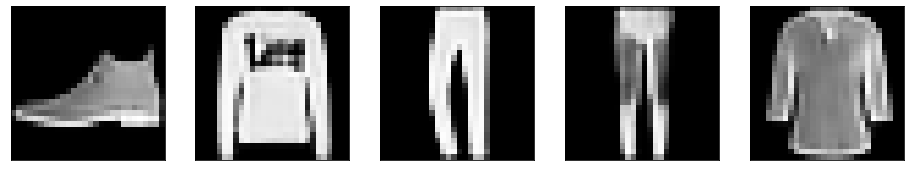

In [ ]:
# Predictions Visualization
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()


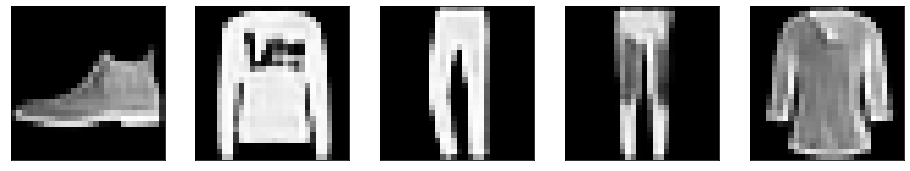

In [ ]:
# Predictions Visualization (Channel)
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_channel[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

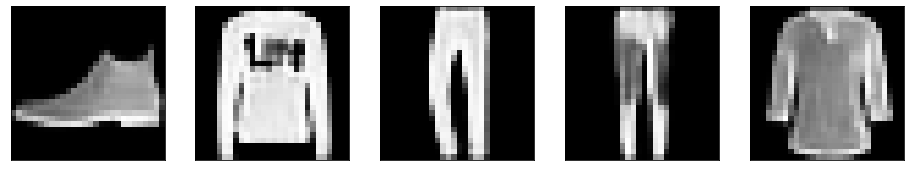

In [ ]:
# Predictions Visualization (spatial)
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_spatial[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

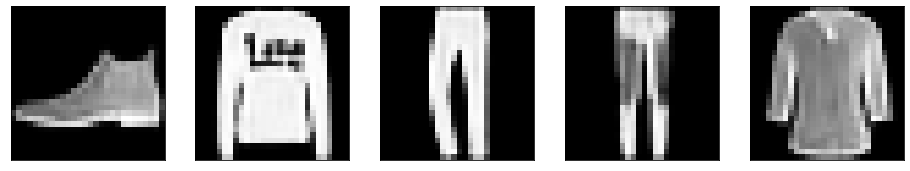

In [ ]:
# Predictions Visualization (parellel_add)
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_parellel_add[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

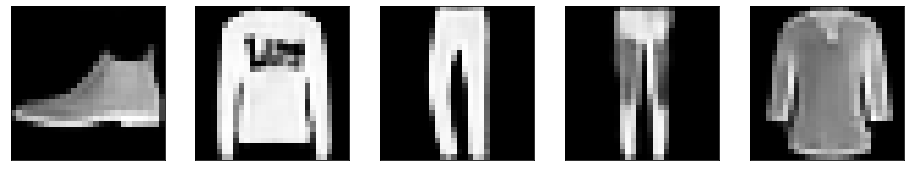

In [ ]:
# Predictions Visualization (parellel_mul)
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_parellel_mul[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

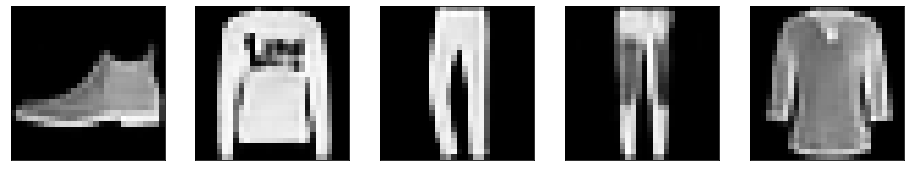

In [ ]:
# Predictions Visualization (serial_ca[)
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_serial_ca[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

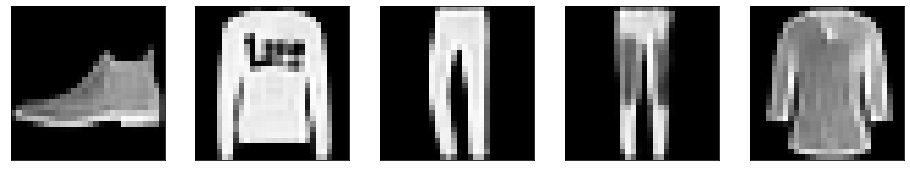

In [ ]:
# Predictions Visualization (serial_sa[)
fig = plt.figure(figsize=(16, 10))

for i in range(5):
    axes = fig.add_subplot(1, 5, i+1)
    axes.imshow(recons_serial_sa[i], cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])

plt.show()

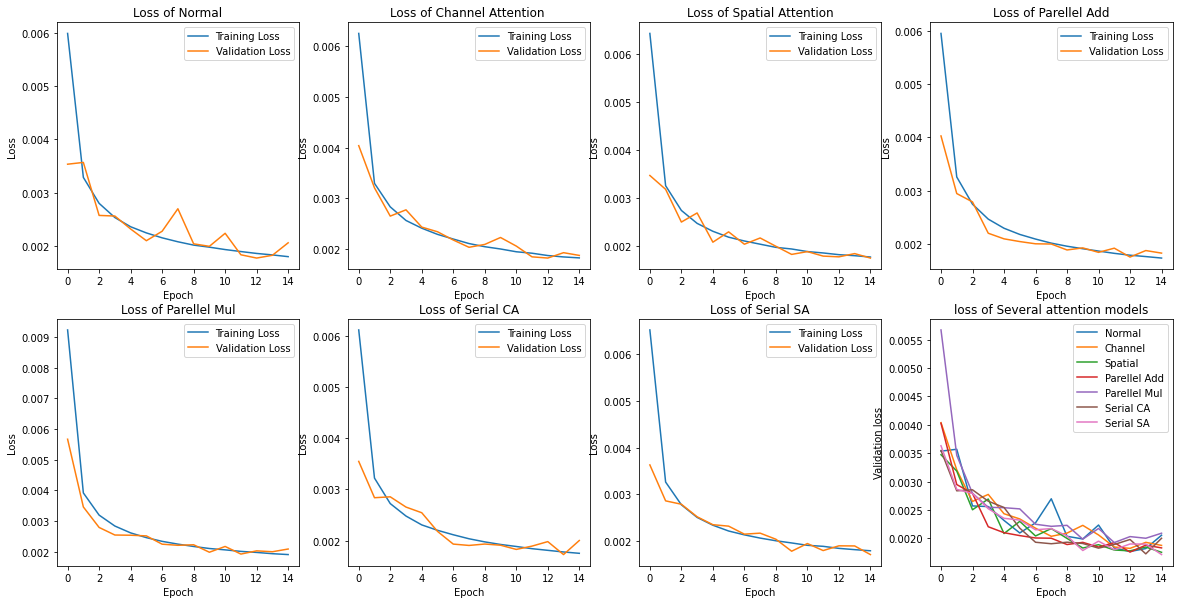

In [ ]:
plt.figure(figsize=(20, 10))

# nomal
plt.subplot(241)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of Normal')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)
# channel
plt.subplot(242)
plt.plot(history_channel.history['loss'])
plt.plot(history_channel.history['val_loss'])
plt.title('Loss of Channel Attention ')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)
# spatial
plt.subplot(243)
plt.plot(history_spatial.history['loss'])
plt.plot(history_spatial.history['val_loss'])
plt.title('Loss of Spatial Attention')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)
# parellel add
plt.subplot(244)
plt.plot(history_parellel_add.history['loss'])
plt.plot(history_parellel_add.history['val_loss'])
plt.title('Loss of Parellel Add')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)
# parellel multi
plt.subplot(245)
plt.plot(history_parellel_mul.history['loss'])
plt.plot(history_parellel_mul.history['val_loss'])
plt.title('Loss of Parellel Mul')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)
# serial ca
plt.subplot(246)
plt.plot(history_serial_ca.history['loss'])
plt.plot(history_serial_ca.history['val_loss'])
plt.title('Loss of Serial CA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)
# serial sa
plt.subplot(247)
plt.plot(history_serial_sa.history['loss'])
plt.plot(history_serial_sa.history['val_loss'])
plt.title('Loss of Serial SA')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.subplot(248)
plt.plot(history.history['val_loss'])
plt.plot(history_channel.history['val_loss'])
plt.plot(history_spatial.history['val_loss'])
plt.plot(history_parellel_add.history['val_loss'])
plt.plot(history_parellel_mul.history['val_loss'])
plt.plot(history_serial_ca.history['val_loss'])
plt.plot(history_serial_sa.history['val_loss'])

plt.title('loss of Several attention models')
plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.legend(['Normal', 'Channel','Spatial','Parellel Add','Parellel Mul','Serial CA','Serial SA'], loc=0)


plt.show()